Two different plots:

1: 2x2 plot comparing max and average results for both bs=32 and bs=256
2: 4 plots, comparing bs=32 and bs256 in single plot

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
from itertools import chain
import numpy as np
import glob

lines = ["b", "g", "r", "orange", "purple"]
colors1 = sns.color_palette("hls", 8)
colors2 = sns.color_palette("husl", 8)
markers = ["*", "s", "^", "o"]

In [2]:
def plot_exp(exp_names, exps, title, metric, baseline=None):
    for i, (exp, exp_path) in enumerate(zip(exp_names, exps)):
        with open(exp_path, "r") as f:
            results = json.load(f)        
        plt.plot(range(1, len(results[metric])+1), results[metric], color=colors2[i], linestyle="-", marker=markers[i], label=f"{exp}")
    if baseline:
        plt.plot(range(1, len(results[metric])+1), [baseline for _ in range(len(results[metric]))], color="black", linestyle=":", label="Supervised")    
    plt.xlabel("Generation")
    plt.ylabel("Test Accuracy")
    plt.xticks=(range(len(results[metric])))
    plt.legend(bbox_to_anchor=(1.5, 1.02))
    plt.suptitle(title)
    plt.show() 
    plt.clf()

def plot_exp_on_ax(exp_names, exps, title, metric, ax,  baseline=None, color_dict=None, marker_dict=None):
    for i, (exp, exp_path) in enumerate(zip(exp_names, exps)):
        with open(exp_path, "r") as f:
            results = json.load(f)        
        ax.plot(range(1, len(results[metric])+1), results[metric], color=color_dict[exp] if color_dict else colors2[i], linestyle="-", marker=marker_dict[exp] if marker_dict else markers[i], label=f"{exp}")
    if baseline:
        ax.plot(range(1, len(results[metric])+1), [baseline for _ in range(len(results[metric]))], color="black", linestyle=":", label="Supervised")    
    ax.xticks=(range(len(results[metric])))
    ax.set_title(title)

def get_data_from_dir(exp_dir):
    # get op, int format data from exp_dir
    exps = glob.glob(os.path.join(exp_dir, "*/"))
    chromos = []
    for e in exps:
        seed = e.split("/")[-2]
        with open(os.path.join(e, "outcomes.json"), "r") as f:
            results = json.load(f)
            for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
                c = list(chain.from_iterable(chromo[1]))
                c.append(seed)
                c.append(fitness[1])
                chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns.append("seed")
    columns.append("test acc")
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+2])
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-2] = int(c[-2])
            chromos_long[i][-1] = c[-1]
    columns_long = list(ops) + ["seed", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    return df, df_long, ops

def get_data(exp_path):
    chromos = []
    with open(exp_path, "r") as f:
        results = json.load(f)
        for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
            c = list(chain.from_iterable(chromo[1]))
            c.append(fitness[1])
            chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns.append("test acc")
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+1])
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-1] = c[-1]
    columns_long = list(ops) + ["fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    return df, df_long, ops

In [3]:
def get_algorithm(params_path):
    with open(params_path, "r") as f:
        params = []
        for i, l in enumerate(f.readlines()):
            params.append(l)
    # get params
    ssl = [j.split(" ")[1].strip("\n") for j in params if "ssl_task" in j][0]
    return ssl

In [4]:
b256_fs = glob.glob("/home/noah/ESSL/final_exps/optimization/exp8*/*")
b256 = [os.path.join(f, "outcomes.json") for f in b256_fs]
b256_names = [get_algorithm(os.path.join(f, "params.txt")) for f in b256_fs]

b32_fs = glob.glob("/home/noah/ESSL/final_exps/optimization/exp6*/*")
b32 = [os.path.join(f, "outcomes.json") for f in b32_fs]
b32_names = [get_algorithm(os.path.join(f, "params.txt")) for f in b32_fs]

color_dict = {name: colors2[i] for i, name in enumerate(set(b32_names + b256_names))}
marker_dict= {name: markers[i] for i, name in enumerate(set(b32_names + b256_names))}

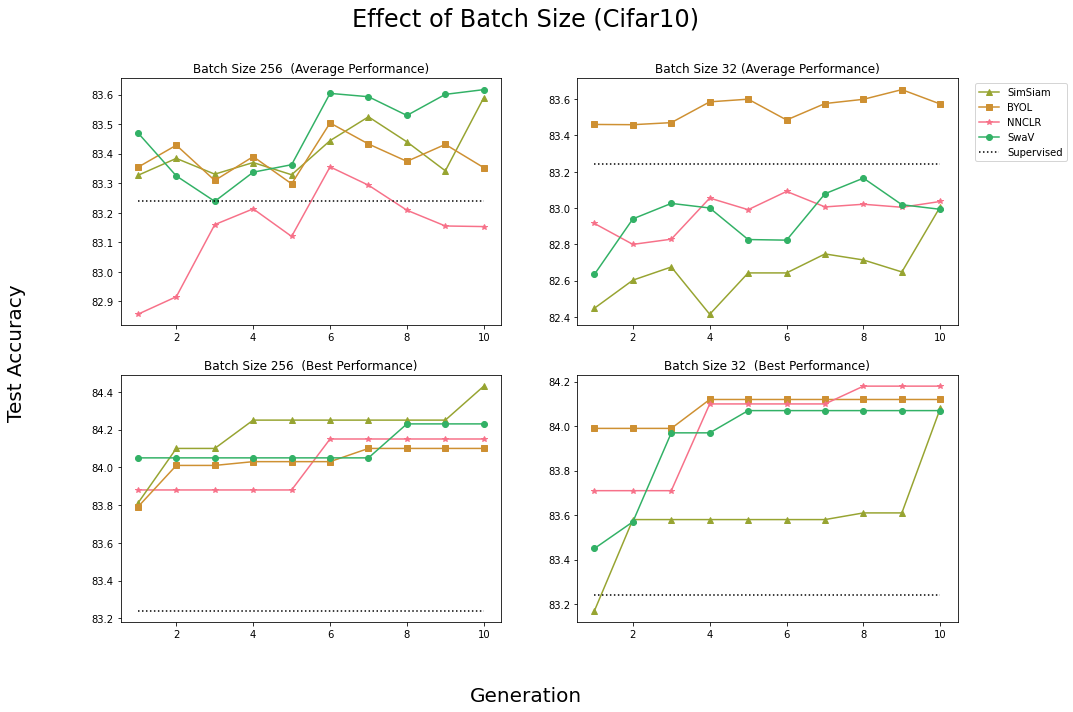

<Figure size 432x288 with 0 Axes>

In [5]:
# plot 2x2 of figures
fig, ax = plt.subplots(2,2, figsize=(15, 10))
plot_exp_on_ax(exp_names=b256_names, exps=b256, title="Batch Size 256  (Average Performance)", metric="avg", ax=ax[0,0],  baseline=83.24, color_dict=color_dict, marker_dict=marker_dict)
plot_exp_on_ax(exp_names=b256_names, exps=b256, title="Batch Size 256  (Best Performance)", metric="max", ax=ax[1,0],  baseline=83.24, color_dict=color_dict, marker_dict=marker_dict)
plot_exp_on_ax(exp_names=b32_names, exps=b32, title="Batch Size 32 (Average Performance)", metric="avg", ax=ax[0,1],  baseline=83.24, color_dict=color_dict, marker_dict=marker_dict)
plot_exp_on_ax(exp_names=b32_names, exps=b32, title="Batch Size 32  (Best Performance)", metric="max", ax=ax[1,1],  baseline=83.24, color_dict=color_dict, marker_dict=marker_dict)
plt.legend(bbox_to_anchor=(1.3, 2.2))
fig.supxlabel("Generation", fontsize=20)
fig.supylabel("Test Accuracy", fontsize=20)
fig.suptitle("Effect of Batch Size (Cifar10)", fontsize=24)

plt.show()
plt.clf()

In [6]:
b256_fs_svhn = glob.glob("/home/noah/ESSL/final_exps/optimization/exp10*/*")
b256_svhn = [os.path.join(f, "outcomes.json") for f in b256_fs_svhn]
b256_names_svhn = [get_algorithm(os.path.join(f, "params.txt")) for f in b256_fs_svhn]

b32_fs_svhn = glob.glob("/home/noah/ESSL/final_exps/optimization/exp11*/*")
b32_svhn = [os.path.join(f, "outcomes.json") for f in b32_fs_svhn]
b32_names_svhn = [get_algorithm(os.path.join(f, "params.txt")) for f in b32_fs_svhn]


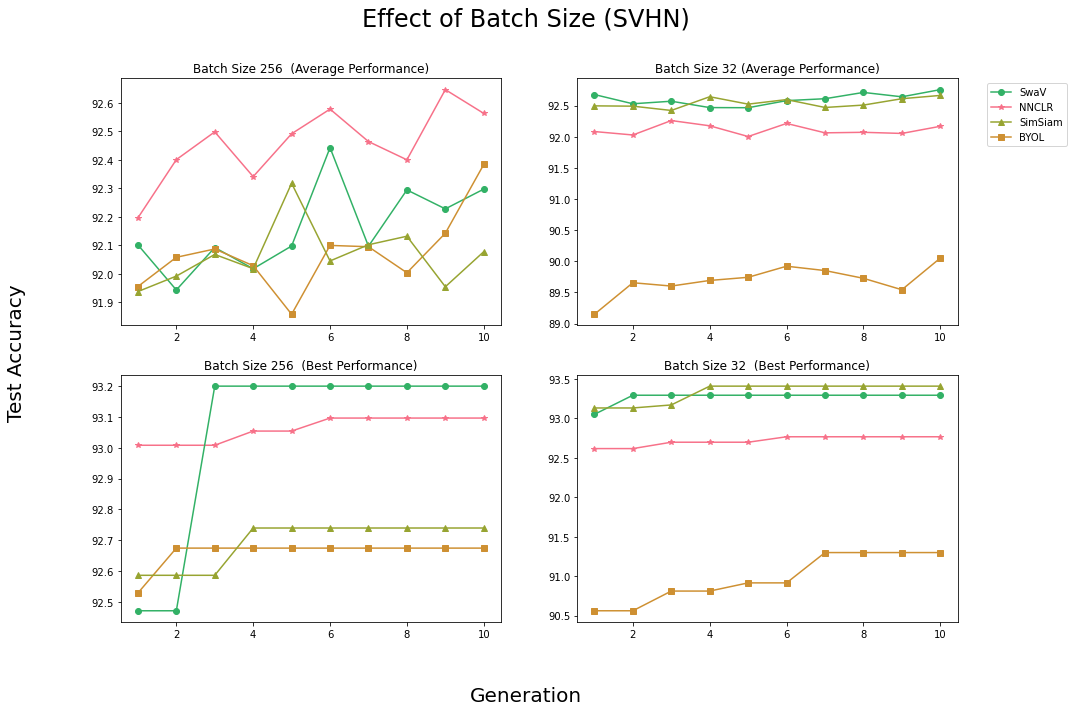

<Figure size 432x288 with 0 Axes>

In [7]:
# plot 2x2 of figures
fig, ax = plt.subplots(2,2, figsize=(15, 10))
plot_exp_on_ax(exp_names=b256_names_svhn, exps=b256_svhn, title="Batch Size 256  (Average Performance)", metric="avg", ax=ax[0,0], color_dict=color_dict, marker_dict=marker_dict)
plot_exp_on_ax(exp_names=b256_names_svhn, exps=b256_svhn, title="Batch Size 256  (Best Performance)", metric="max", ax=ax[1,0], color_dict=color_dict, marker_dict=marker_dict)
plot_exp_on_ax(exp_names=b32_names_svhn, exps=b32_svhn, title="Batch Size 32 (Average Performance)", metric="avg", ax=ax[0,1], color_dict=color_dict, marker_dict=marker_dict)
plot_exp_on_ax(exp_names=b32_names_svhn, exps=b32_svhn, title="Batch Size 32  (Best Performance)", metric="max", ax=ax[1,1], color_dict=color_dict, marker_dict=marker_dict)
plt.legend(bbox_to_anchor=(1.3, 2.2))
fig.supxlabel("Generation", fontsize=20)
fig.supylabel("Test Accuracy", fontsize=20)
fig.suptitle("Effect of Batch Size (SVHN)", fontsize=24)

plt.show()
plt.clf()

In [8]:
# # create a dict mapping for each experiment
# b256_map = {k:v for k, v in zip(b256_names, b256)}
# b32_map = {k:v for k, v in zip(b32_names, b32)}
# for k in b256_map:
#     exps = [b32_map[k], b256_map[k]]
#     exp_names = ["BS=32", "BS=256"]
#     title = f" Batch Size Comparison, {k} (Best Result)"
#     metric="max"
#     plot_exp(exp_names, exps, title, metric, baseline=True)

In [9]:
# # create a dict mapping for each experiment
# b256_map = {k:v for k, v in zip(b256_names, b256)}
# b32_map = {k:v for k, v in zip(b32_names, b32)}
# for k in b256_map:
#     exps = [b32_map[k], b256_map[k]]
#     exp_names = ["BS=32", "BS=256"]
#     title = f" Batch Size Comparison, {k} (Average Result)"
#     metric="avg"
#     plot_exp(exp_names, exps, title, metric, baseline=True)